# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [2]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import textwrap
import torch

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


from utils import *
from dataset import *
from plots import *

## Load data

Let's load the metadata and the images.

In [3]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [4]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

03:14:06 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR82_IM-2350-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [5]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR82_IM-2350-3001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
1,CXR82_IM-2350-4001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
2,CXR173_IM-0481-1001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
3,CXR173_IM-0481-2001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
4,CXR3676_IM-1829-0001-0001.png,Comparison is XXXX to XXXX examination dated X...,XXXX-year-old male with XXXX.,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...


In [6]:
N = 1000
np_images = load_images(metadata[:N], IMAGE_PATH)
images = torch.tensor(np_images)

There are images from two views: frontal and lateral.

In [20]:
# @TODO: Are we working with AP or PA?

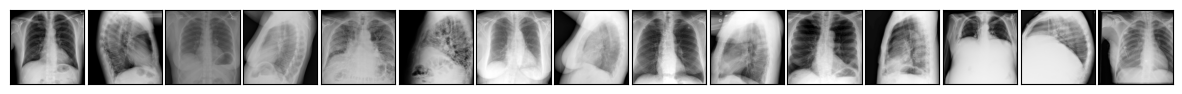

In [26]:
plot_images(images[:15])

Time to plot some X-ray images and the corresponding findings!

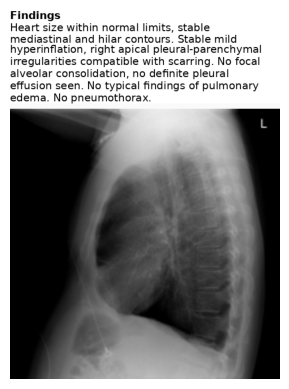

In [8]:
k = 120

title = "Findings"
textbody = metadata.iloc[k]["findings"]
assert textbody != None, "Failed to find findings tag"

image = np_images[k]

plot_text_and_image(textbody, title, image)

## Preprocess Text and Images

In [29]:
# @TODO: read https://arxiv.org/pdf/1711.08195v3.pdf
# @TODO: tokenization, embedding
# @TODO: transformer model